# Investigating different initialization techniques

Although there are many librairies (such as Keras or Tensorflow) to make a neural network in Python, we will be making from scratch using Numpy.
The goal is to get a better understanding of each step of the training process, in particular the forward pass and the backpropagation algorithm. Then we will compare how different initializing techniques for the weights such as the Xavier initializing on a deep neural network affect the training process.

To test our netwrok, we will be using the MNIST dataset.<br>
The __[MNIST dataset](http://yann.lecun.com/exdb/mnist/)__ consists of 70000 labelled pictures of hand-written digits (from 0-9). The pictures have a size of 28 by 28 pixels.<br>

The architecture of the network will be a simple fully connected network. The neural network will be trained to predict the digit on the picture.<br>


In [69]:
# use the preloaded keras datasets and models
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/

/bin/sh: realpath: command not found
ln: ./datasets: File exists
/bin/sh: realpath: command not found
ln: ./models: File exists


In [70]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
np.random.seed(42)

 ## Defining the classes and functions
The main class is a layer for: a layer that will have two functions, one for the forward propagation and the backpropagation.

In [71]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__ (self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self,input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

## Building blocks of the network

The building blocks for the netwotk are:
- Dense layer - a fully-connected layer
- ReLU layer
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer - ReLU 

Let's start with the simplest layer. It applies a nonlinearity to each element of the network.
The activation (non-linear) function used is the ReLU (rectified linear unit) function. The ReLU function is defined as:<br><br>
\begin{align}
\ \sigma(x) & = max(0,x)  \\
\end{align}

An activation function should be differentiable in order to perform backpropagation. As the ReLU fucntion is not continuous, it is not differentiable at x=0, however this not a problem. The derivative of the of the ReLU function is:<br><br>
\begin{align}
\ \sigma'(x) & = 1 \  \ if \ \ x>0  \\
\ and \\
\ \sigma'(x) & = 0 \  \ if \ \ x>0  \\
\end{align}

The graph of the ReLU function is plotted below:

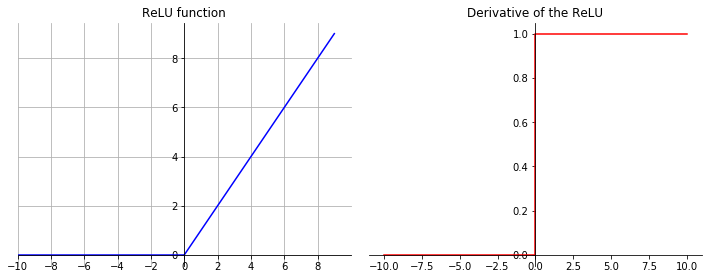

In [838]:
x1 = np.arange(0,10)
x2 = np.arange(-10,1)
z= np.zeros(11)
x3 = [-10,0,10]
y = [0,1,1]
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
#ReLU
ax = axes[0]
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(x1, c='b')
ax.plot(x2,z, c='b')
ax.set_xlim(-10,10)
ax.xaxis.set_ticks(np.arange(-10, 10, 2))
ax.set_title('ReLU function')
ax.grid()
#Derivative
ax = axes[1]
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(x3, y, drawstyle='steps-post', c='r')
ax.set_title('Derivative of the ReLU')
plt.tight_layout()
plt.show()

#### Dead ReLU

The ReLU is one of the most common activation functions since __[it has been shown to train six times faster](https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf)__ than the tanh activation function on CNNs. This is expected as the sigmoid and tanh are computationally expensive whereas the ReLU function is easy to compute and its derivative can only take two values.<br><br>
The ReLU function has also another advantage over the tanh and the sigmoid functions as it solves the problem of the vanishing gradients. Vanishing gradients happen because the sigmoid and tanh functions have a horizontal assymptote for very small and large values, this means that the derivative becomes closer to zero and the weights no longer update.<br>
Looking at the graph of the ReLU function and its derivative, we can see that a similar problem can arise. The weights and the biases can reach values such that no matter the value in the input space the output is negative and therefore the derivative is always zero. Those units are referred as __[Dead ReLU units](https://youtu.be/gYpoJMlgyXA?t=20m54s)__ as they are never activated.<br><br>
The gradients of the ReLU function will be stored as a way to monitor dead ReLU units.



In [628]:
class ReLU(Layer):
    def __init__(self, input_units,batch_size):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        
        #Array to keep track of the number of activations
        self.grad_Relu = np.zeros((batch_size,input_units))
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        self.grad_Relu += relu_grad
        return grad_output*relu_grad        

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(\textbf{X})= \textbf{W} \cdot \textbf{X} +  \textbf{b} $$

Where 
* __X__ is an object-feature matrix of shape [batch_size,num_features],
* __W__ is a weight matrix [batch_size,num_outputs] 
* and __b__ is a vector of num_outputs biases.

Both __W__ and __b__ are initialized during layer creation and updated each time backward is called.

#### Initialization

__Bias__


All the biases are initialized to zero. Since the weights will be initialized to different random values the first update through backpropagation will be different for each bias.

__Weight__

The initializing of weights can greatly affect the training as if it can result in either exploding and vanishing gradients. This is especially problematic in deep neural networks.<br>The weights will be initialized randomly using a Gaussian distribution with mean of 0. Different values for the variance will be explored.<br><br>
The graph below shows the normal distribution with mean 0 and two different values of the variance. The variance represents the width of the curve.

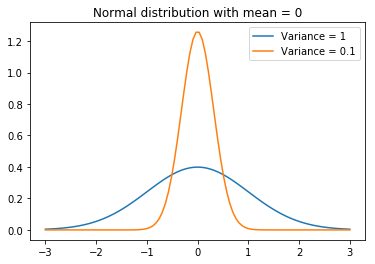

In [629]:
import matplotlib.mlab as mlab


x = np.linspace(-3, 3, 100)
plt.plot(x,mlab.normpdf(x, 0, 1), label = 'Variance = 1')
plt.plot(x,mlab.normpdf(x, 0, np.sqrt(0.1)), label = 'Variance = 0.1')
plt.title('Normal distribution with mean = 0')
plt.legend(loc='best')
plt.show()

The different methods to initialize the weights that will be investigated are as follow:
* small variance, $Var(x) = 0.01 (=\frac{1}{100})$<br><br>
* large variance, $Var(x) =  0.02$<br><br>
* __[Xavier normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)__, $Var(x) = \frac{2}{n_{in}+n_{out}}$ <br><br>
* __[Xavier uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)__, $Var(x) = \frac{6}{n_{in}+n_{out}}$<br><br>
* __[He normal](https://arxiv.org/pdf/1502.01852.pdf)__,$Var(x) = \frac{2}{n_{in}}$ <br><br>
* __[LeCun normal](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)__, $Var(x) = \frac{1}{n_{in}}$<br><br>
Where $n_{in}$ represents the number of input units and $n_{out}$ the number of output units of the layer.<br>




In [891]:
#the different initializers
initializers = ['normal_small', 'normal_large', 'xavier_normal', 'xavier_uniform', 
                'he_normal', 'lecun_normal']

In [892]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, initializer = 'normal_small'):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        initializer : initialize the values of the weights. The possible arguments are: 
        normal_small, normal_large, xavier_normal, xavier_uniform, he_normal, he_uniform, lecun_normal
        """
        self.learning_rate = learning_rate
        
        # initialize weights 
        if initializer == 'normal_small':
            std = 0.1
        elif initializer == 'normal_large':
            std = np.sqrt(0.02)
        elif initializer == 'xavier_normal':
            std = np.sqrt(2/(input_units+output_units))
        elif initializer == 'xavier_uniform':
            std = np.sqrt(6/(input_units+output_units))
        elif initializer == 'he_normal':
            std = np.sqrt(2/input_units)
        elif initializer == 'lecun_normal':
            std = np.sqrt(1/input_units)
        self.weights = np.random.randn(input_units, output_units)*std
        
        #initialize biases
        self.biases = np.zeros(output_units)
        
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return (np.dot(input,self.weights)+self.biases)
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)/x.shape[0]
        grad_biases = grad_output.mean(axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate*grad_weights
        self.biases = self.biases - self.learning_rate*grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.


In [893]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch, n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch, n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return - ones_for_answers + softmax

### Full network

Let's start by loading the dataset.

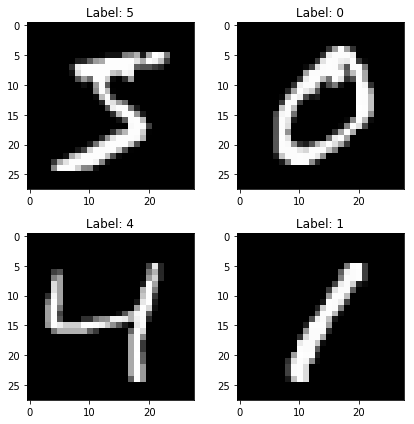

In [894]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.tight_layout()
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

#### Setting the hyper-parameters

Initialization seems to affect more deep neural networks (with more than 5 layers) rather than shallow ones. The network chosen investigated here consist of 9 hidden layers all with ReLU activation. In order to compare the effects of the diffrent initialzations the number of units in different layers varies.<br>
The architecture is as follow:<br>
* Input: 784<br>
* Hidden layer 1: 300, activation: ReLU<br>
* Hidden layer 2: 300, activation: ReLU<br>
* Hidden layer 3: 200, activation: ReLU<br>
* Hidden layer 4: 200, activation: ReLU<br>
* Hidden layer 5: 100, activation: ReLU<br>
* Hidden layer 6: 100, activation: ReLU<br>
* Hidden layer 7: 75, activation: ReLU<br>
* Hidden layer 8: 50, activation: ReLU<br>
* Hidden layer 9: 50, activation: ReLU<br>
* Output: 10, activation softmax<br>

As the aim is to investigate the effect of the initialization of the weights on the learning, the learning rate was chosen to be fairly high (0.1) so that the weights update quickly. To avoid too much over-fitting and considering that the learning rate is large, the number of epochs is kept relatively low at 25. <br>

Mini-batch of size 32 will be used in order to obtain a good compromise between regular updates of the weights and speed of training.<br>
Note: Better accuracy can be obtained on this dataset with shallower network, but as the aim this investigation is to investigate the influence of the initialization of the weights the network was chosen to be deeper than required.

In [895]:
#hyper parameters
learning_rate = 0.1

batch_size = 32

num_epochs = 25

num_layers = 9

layer_output = [300,300,200,200,100,100,75,50,50]

In [896]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:      
        activations.append(layer.forward(input))
        input = layer.forward(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # propagate gradients through the network
    for i in range(len(network)-1,-1,-1):
        loss_grad = network[i].backward(layer_inputs[i],loss_grad)
         
        
    return np.mean(loss)

### Training loop

Mini-batch implementation:

In [897]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

#### Training

Note: the training will take some time as we are training 6 different networks for 25 epochs.

In [899]:
all_train_log = []
all_val_log = []
test_log = []
activations = []
he_activations = []
for init in initializers:
    #Initialize the network
    network = []
    network.append(Dense(X_train.shape[1],layer_output[0],learning_rate=learning_rate, initializer = init))
    for i in range(num_layers-1):
        network.append(ReLU(layer_output[i], batch_size))
        network.append(Dense(layer_output[i],layer_output[i+1],learning_rate=learning_rate, initializer = init))
    network.append(ReLU(layer_output[num_layers-1], batch_size))
    network.append(Dense(layer_output[num_layers-1],10,learning_rate=learning_rate, initializer = init))
    train_log = []
    val_log = []
    #Training
    print('Training for initializer: {}'.format(init))
    for epoch in range(num_epochs):        
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize = batch_size,shuffle=True):
            train(network,x_batch,y_batch)
        train_acc = np.mean(predict(network,X_train)==y_train)
        val_acc = np.mean(predict(network,X_val)==y_val)
        train_log.append(train_acc)
        val_log.append(val_acc)
        print('Epoch: {}'.format(epoch))
        print('Training accuracy: {}'.format(train_acc))
        print('Validation accuracy: {}'.format(val_acc))
    clear_output()
    all_train_log.append(train_log)
    all_val_log.append(val_log)
    test_log.append(np.mean(predict(network,X_test)==y_test))
    
    #keeping track of the activations
    activation_perc_all_layers = []
    for i in range(num_layers):
        s = np.zeros(layer_output[i])
        for a in network[2*i+1].grad_Relu:
            s+=a
        s = s/(int(50000/batch_size)*batch_size*num_epochs)*100
        activation_perc_all_layers = np.concatenate((activation_perc_all_layers,s))
    activations.append(activation_perc_all_layers)
print('All networks have been trained.')

All networks have been trained.


## Results

To analyze the results, we will consider the accuracy against the test set, the change of the training and validation accuracy through the different epochs, overfitting and a estimation of the number of dead ReLU units.

#### Test accuracy

In [907]:
#Final Test accuray comparaison
print('The accuracy on the test data is:')
for i in range(len(initializers)):
    print(initializers[i]+': {:.4f}%'.format(test_log[i]*100))

The accuracy on the test data is:
normal_small: 96.9300%
normal_large: 97.5000%
xavier_normal: 98.1200%
xavier_uniform: 97.5500%
he_normal: 98.1000%
lecun_normal: 98.1500%


Recall:
* small variance, $Var(x) = 0.01 (=\frac{1}{100})$<br><br>
* large variance, $Var(x) =  0.02$<br><br>
* __[Xavier normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)__, $Var(x) = \frac{2}{n_{in}+n_{out}}$ <br><br>
* __[Xavier uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)__, $Var(x) = \frac{6}{n_{in}+n_{out}}$<br><br>
* __[He normal](https://arxiv.org/pdf/1502.01852.pdf)__,$Var(x) = \frac{2}{n_{in}}$ <br><br>
* __[LeCun normal](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)__, $Var(x) = \frac{1}{n_{in}}$<br><br>
Where $n_{in}$ represents the number of input units and $n_{out}$ the number of output units of the layer.<br>

It appears that the initialization methods that result in the best test accuracy results are:
Xavier normal, He normal and LeCun normal, all of them yielding to results that are very close.<br>
The initialization of the weights with a variance of 0.01 gives the worst result. It is worth noting that the mean of all $\frac{1}{n_{in}}$ is equal to 0.01 (see cell below), so one could have expected this initialization to give similar results to the LeCun initialization as on average the variance is the same.



In [912]:
np.mean([1/300,1/300,1/200,1/200,1/100,1/100,1/75,1/50,1/50])

0.01

#### Training and validation accuracy

Let's take a look at the training and validation accuracy through the different epochs.

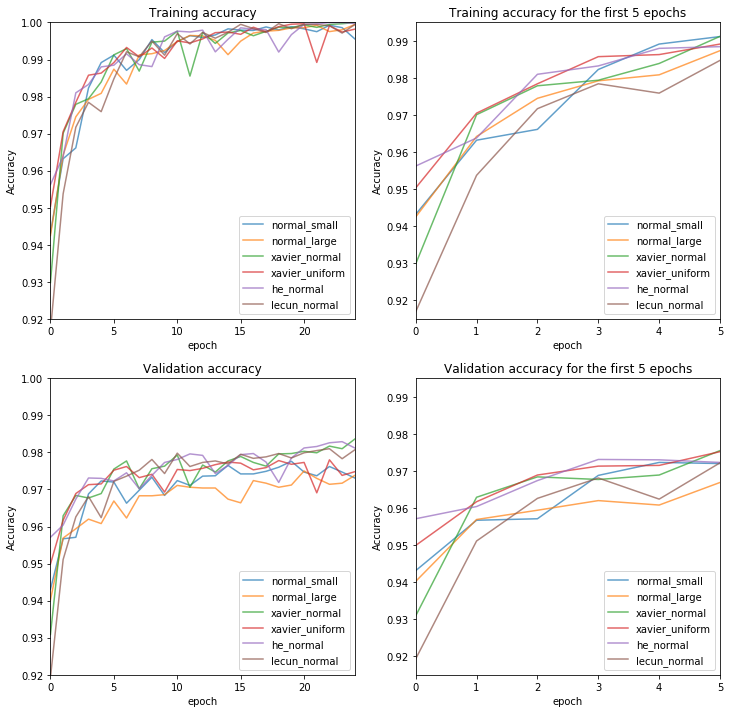

In [946]:
#Graph to compare results
plt.figure(figsize=[12,12])
plt.subplot(2,2,1)
for i in range(len(initializers)):
    plt.plot(all_train_log[i], label = initializers[i], alpha = 0.7)
plt.ylim(0.92,1)
plt.xlim(0,24)
plt.title('Training accuracy')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,2)
for i in range(len(initializers)):
    plt.plot(all_train_log[i], label = initializers[i], alpha = 0.7)
plt.xlim(0,5)
plt.ylim(0.915,0.995)
plt.title('Training accuracy for the first 5 epochs')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,3)
for i in range(len(initializers)):
    plt.plot(all_val_log[i], label = initializers[i], alpha = 0.7)
plt.ylim(0.92,1)
plt.xlim(0,24)
plt.title('Validation accuracy')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.subplot(2,2,4)
for i in range(len(initializers)):
    plt.plot(all_val_log[i], label = initializers[i], alpha = 0.7)
plt.xlim(0,5)
plt.ylim(0.915,0.995)
plt.title('Validation accuracy for the first 5 epochs')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

Looking at the training accuracy it is clear that all the models are overfitting (this will discussed in more details in the next section) and that they seem to converge after roughly the same number of epochs even if some fluctuations can be seen.<br>
The He normal initialization reaches the highest validation accuracy after 1 epoch with a value of 0.957, this seems to indicate that this method converges the fastest, whereas the validation accuracy after 1 epoch using the LeCun initialization is the lowest (0.919).

#### Overfitting

To estimate the amount of overfitting from the model, the difference between the training accuracy at the last epoch and the test accuracy is calculated for each of the initialization method is calculated. The higher the value, the more overfitting.

In [955]:
#Overfitting tendancy
overfit = []
for i in range (len(all_train_log)):
    overfit.append(all_train_log[i][num_epochs-1] - all_val_log[i][num_epochs-1])
for i in range(len(initializers)):
    print(initializers[i]+': {:.4f}'.format(overfit[i]))

normal_small: 0.0225
normal_large: 0.0256
xavier_normal: 0.0164
xavier_uniform: 0.0234
he_normal: 0.0185
lecun_normal: 0.0187


It can be noted that the model that resulted in the lowest test accuracies are also the models that appear to be overfitting the most. This should not be surprising as overfitting is often a cause of low test accuracy. 

#### Dead ReLU

Finally we estimate the amount of Dead ReLU units for each model. The number of times each unit in the model was activated (when the derivative of the ReLU is equal to one) where recorded. Those values where then converted to percentages and then plotted as a histogram below. 


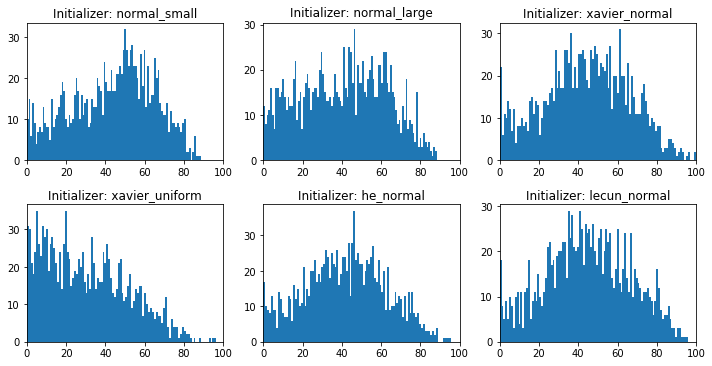

In [962]:
plt.figure(figsize=[10,10])
for i in range(len(initializers)):
    plt.subplot(4,3,i+1)
    plt.title("Initializer: " + initializers[i])
    plt.xlim(0,100)
    plt.hist(activations[i], bins = 100)
    plt.tight_layout()


Most of the histograms have a 'bell' like shape, except for the Xavier uniform for which the majority of the neurons are 'fired' sporadically. <br>
A sign that dead ReLU are present is a minor peak on the left of the graph. The graphs are redrawn to be show this more clearly below.

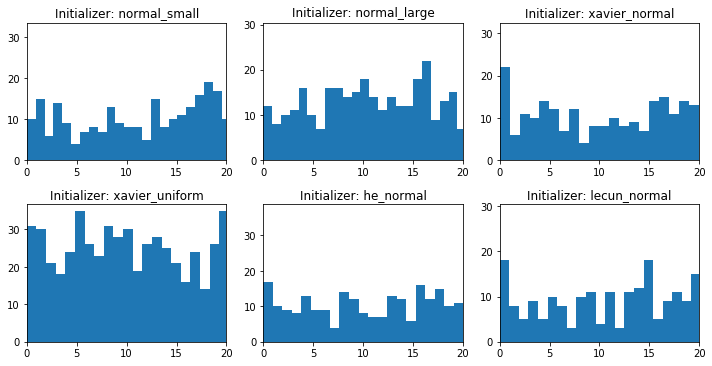

In [959]:
plt.figure(figsize=[10,10])
for i in range(len(initializers)):
    plt.subplot(4,3,i+1)
    plt.title("Initializer: " + initializers[i])
    plt.xlim(0,20)
    plt.hist(activations[i], bins = 100)
    plt.tight_layout()

The bar on the left of the histogram represents the number of units that have been activated at 1% of the time, this gives an estimate of the number of dead ReLU cells. 
It appears that all the models are suffering by some amount of dead ReLUs. As this method gives only an estimate it is difficult to compare the different models with confidence.

## Conclusion


As a conclusion, it is clear that the intialization of the weights has am impact on the rate of training as well as the final test accuracy. The recommended method for initializing the weights are Xavier normal ($Var(x) = \frac{2}{n_{in}+n_{out}}$), He normal ($Var(x) = \frac{2}{n_{in}}$) and LeCun normal ($Var(x) = \frac{1}{n_{in}}$). The He initialization seemed to lead to a faster convergence for a deep fully connected neural network.<br><br>

All the model seem to result to dead ReLUs. One possible solution for dead ReLU units is to replace the ReLU activation by the __[leaky ReLU](https://arxiv.org/abs/1502.01852)__.<br>
Other areas for further investigation, would be to find out whether these results would be similar for other architectures such CNN, RNN etc.
